# Constants

In [67]:
IALAB_MEMBER = True
IALAB_USER = 'mrearle' # Only if you are IALAB_MEMBER

# Imports

In [68]:
import os
import sys

In [69]:
if IALAB_MEMBER:
  matterport_build_path = f'/home/{IALAB_USER}/datasets/Matterport3DSimulator/build'
  metadata_script_path = f'/home/{IALAB_USER}/repos/360-visualization/metadata_parser'
else:
  matterport_build_path = f'/Matterport3DSimulator/build' # Path to simulator
  metadata_script_path = f'/360-visualization/metadata_parser' # Path to metadata parser of this repository

In [79]:
if matterport_build_path not in sys.path:
    sys.path.append(matterport_build_path)

if metadata_script_path not in sys.path:
    sys.path.append(metadata_script_path)

In [71]:
import json
import sys
import MatterSim
import time
import numpy as np
import skimage.transform
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

from parse_house_segmentations import HouseSegmentationFile

# Simulator

In [72]:
# load navigation graph to calculate the relative heading of the next location
def load_nav_graph(graph_path):
    with open(graph_path) as f:
        G = nx.Graph()
        positions = {}
        data = json.load(f)
        for i,item in enumerate(data):
            if item['included']:
                for j,conn in enumerate(item['unobstructed']):
                    if conn and data[j]['included']:
                        positions[item['image_id']] = np.array([item['pose'][3], 
                                item['pose'][7], item['pose'][11]]);
                        assert data[j]['unobstructed'][i], 'Graph should be undirected'
                        G.add_edge(item['image_id'],data[j]['image_id'])
        nx.set_node_attributes(G, values=positions, name='position')
    return G

# compute the relative heading between two objects 
def compute_rel_heading(graph, current_viewpoint, current_heading, next_viewpoint):
    if current_viewpoint == next_viewpoint:
        return 0.
    target_rel = graph.nodes[next_viewpoint]['position'] - graph.nodes[current_viewpoint]['position']
    target_heading = np.pi/2.0 - np.arctan2(target_rel[1], target_rel[0]) # convert to rel to y axis
    
    rel_heading = target_heading - current_heading
    
    # normalize angle into turn into [-pi, pi]
    rel_heading = rel_heading - (2*np.pi) * np.floor((rel_heading + np.pi) / (2*np.pi))
    return rel_heading

In [73]:
def visualize_panorama_img(scan, viewpoint, heading, elevation):
    WIDTH = 80
    HEIGHT = 480
    pano_img = np.zeros((HEIGHT, WIDTH*36, 3), np.uint8)
    VFOV = np.radians(55)
    sim = MatterSim.Simulator()
    sim.setCameraResolution(WIDTH, HEIGHT)
    sim.setCameraVFOV(VFOV)
    sim.initialize()
    for n_angle, angle in enumerate(range(-175, 180, 10)):
        sim.newEpisode([scan], [viewpoint], [heading + np.radians(angle)], [elevation])
        state = sim.getState()
        im = state[0].rgb
        im = np.array(im)
        pano_img[:, WIDTH*n_angle:WIDTH*(n_angle+1), :] = im[..., ::-1]
    return pano_img

def visualize_tunnel_img(scan, viewpoint, heading, elevation):
    WIDTH = 640
    HEIGHT = 480
    VFOV = np.radians(60)
    sim = MatterSim.Simulator()
    sim.setCameraResolution(WIDTH, HEIGHT)
    sim.setCameraVFOV(VFOV)
    sim.init()
    sim.newEpisode(scan, viewpoint, heading, elevation)
    state = sim.getState()
    im = state.rgb
    return im[..., ::-1].copy()

# Metadata Parser

In [74]:
viewpoint = '00ebbf3782c64d74aaf7dd39cd561175'
scan = '17DRP5sb8fy'

In [75]:
base_cache_path = metadata_script_path + '/house_cache'
HouseSegmentationFile.base_cache_path = base_cache_path

In [76]:
metadata = HouseSegmentationFile.load_mapping(scan)

Cached file exists, loading.


In [77]:
objects = metadata.angle_relative_viewpoint_objects(viewpoint)
objects.head()

,object_index,region_index,category_index,px,py,pz,a0x,a0y,a0z,a1x,a1y,a1z,r0,r1,r2,category_mapping_name,distance,heading,elevation
0,64,3,0,0.08678,-0.486544,-0.505510,1,0,0,-0,0,1,1.2787,1.07518,1.07237,wall,0.494222,2.965089,-0.796688
1,65,3,2,0.13652,-0.494245,0.463480,1,0,0,0,1,0,1.22366,1.06192,0.109429,ceiling,0.512753,2.872093,0.734968
2,66,3,3,-0.03813,-0.466407,-1.430133,1,0,0,0,1,0,1.14534,1.0373,0.15117,floor,0.467963,-3.060021,-1.254561
3,67,3,19,1.10277,-0.029361,-0.067110,0,0,1,0,1,-0,0.56005,0.477925,0.0737991,mirror,1.103161,1.597415,-0.060759
4,68,3,1,-0.71965,-0.326582,-0.539370,0,0,1,-0.92388,0.382683,0,1.02612,0.436492,0.113585,door,0.790286,-1.996811,-0.598884


# Visualization

(1440, 2880, 3)


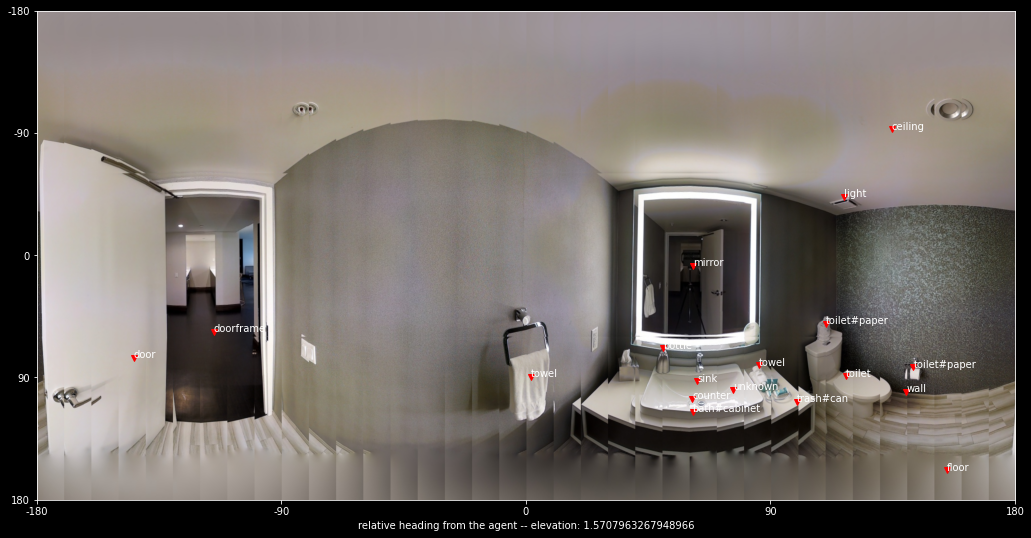

In [116]:
plt.close('all')
viewpoint_heading = np.pi / 6

images = []
for viewpoint_elevation in (np.pi / 2 * x for x in range(-1, 2)):
    im = visualize_panorama_img(scan, viewpoint, viewpoint_heading, viewpoint_elevation)
    images.append(im)

img = np.concatenate(images[::-1], axis=0)

plt.figure(figsize=(18, 9))  
plt.imshow(img)
plt.xticks(np.linspace(0, img.shape[1] - 1, 5), [-180, -90, 0, 90, 180])
plt.xlabel(f'relative heading from the agent')
plt.yticks(np.linspace(0, img.shape[0] - 1, 5), [-180, -90, 0, 90, 180])

x0, y0 = viewpoint_heading, 0
for obj in objects.itertuples():
    heading, elevation = float(obj.heading), float(obj.elevation)
    category = obj.category_mapping_name

    heading -= x0
    while heading > np.pi:
        heading -= 2 * np.pi
    while heading < -np.pi:
        heading += 2 * np.pi

    elevation += y0
    while elevation > np.pi:
        heading -= 2 * np.pi
    while elevation < -np.pi:
        elevation += 2 * np.pi

    first_coord = (heading / (2 * np.pi) + 0.5) * img.shape[1]
    second_coord = (0.5 - elevation / (np.pi / 1.1)) * img.shape[0]

    plt.plot(first_coord, second_coord, color='red', marker='v', linewidth=3)
    plt.annotate(category, (first_coord, second_coord))
        